In [1]:
import json
import math
import pandas as pd # Para mostrar tablas de resultados de forma ordenada

# --- Parámetros de entrada ---
# ¡Asegúrate de que esta ruta sea correcta en tu sistema!
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json'
scenario_key_to_analyze = 'scenario_1'
cti = 0.2 # Coordination Time Interval

# --- Función para analizar la coordinación ---
def analyze_relay_coordination(pairs_data, cti_value):
    """
    Calcula métricas de coordinación (delta_t, MT) para una lista de pares de relés.

    Args:
        pairs_data (list): Una lista de diccionarios, donde cada diccionario representa
                           un registro de par de relés. Se espera que contenga
                           diccionarios anidados 'main_relay' y 'backup_relay',
                           cada uno con una clave 'Time_out'.
        cti_value (float): El Intervalo de Tiempo de Coordinación (CTI).

    Returns:
        tuple: Una tupla conteniendo:
            - float: El Tiempo Total de Descoordinación (TMT).
            - list: Una lista de diccionarios para los pares descoordinados.
            - list: Una lista de diccionarios para todos los pares analizados con sus resultados.
    """
    miscoordinated_pairs = []
    all_pairs_results = []
    total_mt = 0.0
    valid_pairs_count = 0

    if not isinstance(pairs_data, list):
        print(f"Error: Se esperaba una lista de pares de relés para el escenario, pero se recibió {type(pairs_data)}")
        return None, [], [] # Indicar error

    for i, record in enumerate(pairs_data):
        # Validar estructura y existencia de datos necesarios
        main_relay_data = record.get('main_relay')
        backup_relay_data = record.get('backup_relay')

        if not isinstance(main_relay_data, dict) or \
           not isinstance(backup_relay_data, dict) or \
           'Time_out' not in main_relay_data or \
           'Time_out' not in backup_relay_data:
            print(f"Advertencia: Omitiendo registro en índice {i} debido a estructura faltante o 'Time_out' ausente. Registro: {record}")
            continue

        tmj = main_relay_data['Time_out']
        tbj = backup_relay_data['Time_out']
        main_relay_id = main_relay_data.get('relay', f'Principal_{i}')
        backup_relay_id = backup_relay_data.get('relay', f'Respaldo_{i}')
        fault_info = record.get('fault', 'N/A')
        scenario_id = record.get('scenario_id', scenario_key_to_analyze) # Usar el scenario_id del registro si existe

        # Validar que los tiempos sean numéricos
        if not isinstance(tmj, (int, float)) or not isinstance(tbj, (int, float)):
             print(f"Advertencia: Omitiendo registro en índice {i} debido a 'Time_out' no numérico. tmj: {tmj}, tbj: {tbj}")
             continue

        valid_pairs_count += 1 # Contar par válido

        # Calcular delta_t (∆tmbj = tbj - tmj - CTI)
        delta_t = tbj - tmj - cti_value

        # Calcular Tiempo de Descoordinación (MTj = (∆tmbj - |∆tmbj|) / 2)
        # MTj es <= 0. Es 0 si delta_t >= 0 (coordinado), y negativo si delta_t < 0 (descoordinado)
        mt = (delta_t - abs(delta_t)) / 2.0

        total_mt += mt

        # Almacenar resultados detallados para este par
        pair_result = {
            'scenario_id': scenario_id,
            'fault': fault_info,
            'main_relay': main_relay_id,
            'backup_relay': backup_relay_id,
            'tmj': tmj,
            'tbj': tbj,
            'delta_t': delta_t,
            'MT': mt
        }
        all_pairs_results.append(pair_result)

        # Identificar si está descoordinado (MT < 0)
        if mt < 0:
            miscoordinated_pairs.append(pair_result)

    if valid_pairs_count == 0 and len(pairs_data) > 0:
         print("Advertencia: Ninguno de los registros proporcionados para el escenario tenía la estructura o datos necesarios.")
         return 0.0, [], [] # Retornar valores vacíos si no se procesó ningún par válido
    elif valid_pairs_count == 0 and len(pairs_data) == 0:
         # No es una advertencia si la lista inicial estaba vacía
         return 0.0, [], []


    return total_mt, miscoordinated_pairs, all_pairs_results

# --- Bloque Principal de Ejecución ---
if __name__ == "__main__":
    data = None
    scenario_data = None

    # 1. Cargar el archivo JSON
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Archivo JSON cargado exitosamente desde: {file_path}")
    except FileNotFoundError:
        print(f"Error Fatal: El archivo no se encontró en la ruta especificada: {file_path}")
        exit() # Salir si el archivo no se encuentra
    except json.JSONDecodeError:
        print(f"Error Fatal: El archivo en {file_path} no es un JSON válido o está mal formateado.")
        exit() # Salir si el JSON es inválido
    except Exception as e:
        print(f"Error Fatal: Ocurrió un error inesperado al leer el archivo: {e}")
        exit() # Salir por otros errores

    # 2. Identificar estructura y filtrar datos para el escenario deseado
    if isinstance(data, dict):
        # Caso 1: El JSON es un diccionario donde las claves son los scenario_id
        if scenario_key_to_analyze in data:
            scenario_data = data[scenario_key_to_analyze]
            print(f"Se encontraron datos para '{scenario_key_to_analyze}' bajo la clave del diccionario.")
            # Asegurarse de que los datos del escenario sean una lista
            if not isinstance(scenario_data, list):
                print(f"Error: Se esperaba una lista de pares para '{scenario_key_to_analyze}', pero se encontró tipo {type(scenario_data)}.")
                scenario_data = None # Marcar como inválido
        else:
            print(f"Error: No se encontró la clave '{scenario_key_to_analyze}' en el diccionario JSON.")
            scenario_data = [] # Vacío para que el análisis no falle pero indique 0

    elif isinstance(data, list):
        # Caso 2: El JSON es una lista de registros, cada uno con una clave 'scenario_id' (u similar)
        # Intentar detectar la clave del escenario (podría ser 'scenario_id', 'scenario', etc.)
        scenario_id_key = 'scenario_id' # Asumir 'scenario_id' por defecto
        if data and isinstance(data[0], dict):
             # Buscar claves comunes para escenario
             possible_keys = ['scenario_id', 'scenario', 'Scenario', 'SCENARIO_ID']
             found_key = None
             for key in possible_keys:
                 if key in data[0]:
                     found_key = key
                     break
             if found_key:
                 scenario_id_key = found_key
                 print(f"Detectada clave de escenario: '{scenario_id_key}'")
                 scenario_data = [item for item in data if item.get(scenario_id_key) == scenario_key_to_analyze]
                 print(f"Se filtraron {len(scenario_data)} registros para '{scenario_key_to_analyze}'.")
             else:
                 # Caso 3: Es una lista, pero no tiene clave de escenario? Asumir que toda la lista es para el escenario? (Menos probable)
                 print(f"Advertencia: El JSON es una lista, pero no se detectó una clave de escenario obvia en el primer registro.")
                 print("Se intentará procesar asumiendo que cada registro tiene la estructura de par main/backup requerida.")
                 # Podríamos asignar toda la data si estamos seguros, pero es arriesgado.
                 # Mejor pedir al usuario que revise el formato.
                 # Por ahora, dejaremos scenario_data como None o lista vacía si no estamos seguros.
                 scenario_data = [] # Opcionalmente: scenario_data = data si se quiere forzar el análisis de toda la lista

        else:
             print("Error: El JSON es una lista, pero no contiene diccionarios o está vacía.")
             scenario_data = []
    else:
        print(f"Error: Formato JSON no reconocido (ni diccionario ni lista). Tipo encontrado: {type(data)}")
        scenario_data = [] # Vacío

    # 3. Realizar el análisis de coordinación si se encontraron datos válidos
    if scenario_data is not None and isinstance(scenario_data, list):
        if not scenario_data:
             print(f"\nNo se encontraron o filtraron registros válidos para '{scenario_key_to_analyze}'.")
             tmt_result = 0.0
             miscoordinated_list = []
             all_results_list = []
        else:
            print(f"\nAnalizando {len(scenario_data)} pares de relés para '{scenario_key_to_analyze}'...")
            tmt_result, miscoordinated_list, all_results_list = analyze_relay_coordination(scenario_data, cti)

            if tmt_result is None: # Indica error en la función de análisis
                 print("Error durante el análisis de coordinación.")
                 # Salir o manejar el error como sea apropiado
                 exit()

        # 4. Imprimir los resultados del análisis
        print(f"\n--- Resultados del Análisis de Coordinación para {scenario_key_to_analyze} (CTI = {cti}) ---")
        print(f"Tiempo Total de Descoordinación (TMT): {tmt_result:.4f}")

        if tmt_result == 0:
            print("\nLa coordinación general es ÓPTIMA (TMT = 0) para los pares analizados.")
            if not miscoordinated_list:
                 print("No se encontraron pares descoordinados.")
            else:
                 # Esto no debería pasar si TMT es 0, pero por si acaso
                 print("Advertencia: TMT es 0 pero se listaron pares descoordinados (revisar lógica).")
        elif tmt_result < 0:
             print(f"\nLa coordinación general presenta PROBLEMAS (TMT < 0).")
             print(f"Se encontraron {len(miscoordinated_list)} par(es) descoordinados:")
             if miscoordinated_list:
                 # Usar pandas para mostrar una tabla bonita
                 df_miscoordinated = pd.DataFrame(miscoordinated_list)
                 # Seleccionar y ordenar columnas para mejor legibilidad
                 cols_display = ['main_relay', 'backup_relay', 'fault', 'tmj', 'tbj', 'delta_t', 'MT']
                 # Asegurar que las columnas existen antes de intentar mostrarlas
                 cols_existing = [col for col in cols_display if col in df_miscoordinated.columns]
                 print(df_miscoordinated[cols_existing].to_markdown(index=False, floatfmt=".4f"))
        else:
             # Este caso (TMT > 0) no debería ocurrir con la fórmula de MT, pero se incluye por robustez
             print(f"Advertencia: TMT es positivo ({tmt_result:.4f}), lo cual es inesperado con la fórmula usada.")

        # Opcional: Imprimir detalles de todos los pares analizados
        # print("\n--- Detalles de Todos los Pares Analizados ---")
        # if all_results_list:
        #     df_all = pd.DataFrame(all_results_list)
        #     cols_display_all = ['main_relay', 'backup_relay', 'fault', 'tmj', 'tbj', 'delta_t', 'MT']
        #     cols_existing_all = [col for col in cols_display_all if col in df_all.columns]
        #     print(df_all[cols_existing_all].to_markdown(index=False, floatfmt=".4f"))
        # else:
        #     print("No hay detalles para mostrar (ningún par fue procesado).")

    else:
        # Mensaje si scenario_data no fue una lista válida o no se pudo determinar
        print("\nNo se pudo proceder con el análisis debido a problemas con los datos o la estructura del JSON.")

Archivo JSON cargado exitosamente desde: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json
Detectada clave de escenario: 'scenario_id'
Se filtraron 100 registros para 'scenario_1'.

Analizando 100 pares de relés para 'scenario_1'...

--- Resultados del Análisis de Coordinación para scenario_1 (CTI = 0.2) ---
Tiempo Total de Descoordinación (TMT): -15.8543

La coordinación general presenta PROBLEMAS (TMT < 0).
Se encontraron 88 par(es) descoordinados:
| main_relay   | backup_relay   |   fault |    tmj |    tbj |   delta_t |      MT |
|:-------------|:---------------|--------:|-------:|-------:|----------:|--------:|
| R38          | R39            |      90 | 0.1989 | 0.3989 |   -0.0000 | -0.0000 |
| R38          | R55            |      90 | 0.1989 | 0.3989 |   -0.0000 | -0.0000 |
| R10          | R9             |      10 | 0.2905 | 0.2965 |   -0.1940 | -0.1940 |
| R47          | R48            |      90 | 0.3008 | 0.3

# *****


Archivo JSON cargado: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json

--- Generando Gráfica Detallada para R10(P) / R9(R) (Falla: 10) ---
  Registro encontrado: Falla=10, Ishc(Main)=1.71, Tmj=0.2905, Tbj=0.2965


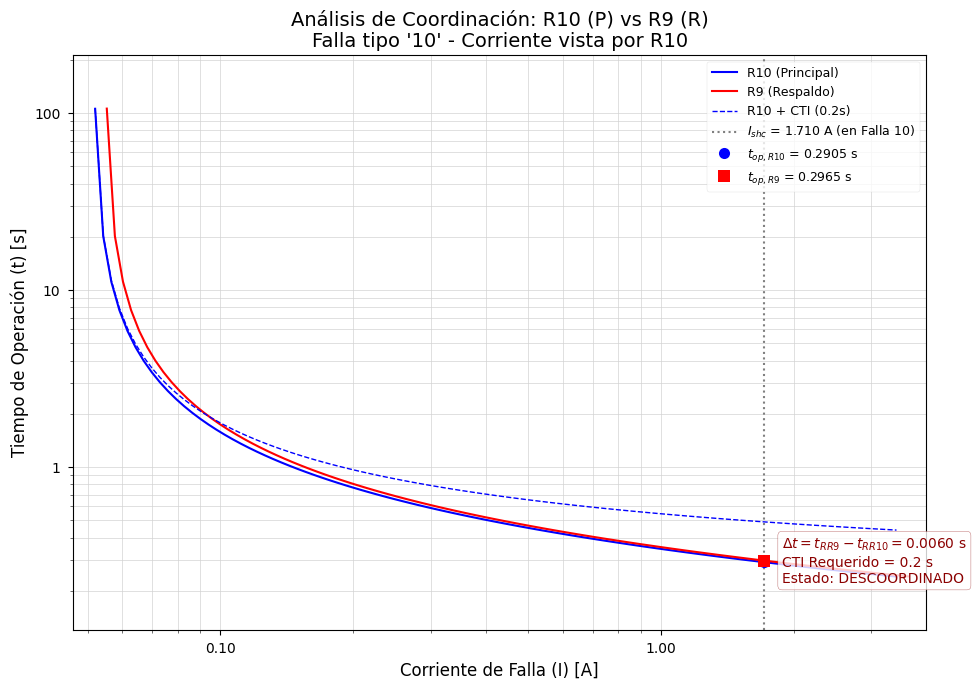


--- Fin del análisis detallado del par R10/R9 ---


In [5]:
# ... (Importaciones y funciones anteriores: json, math, np, pd, analyze_relay_coordination, calculate_operating_time, extract_relay_parameters) ...
# ¡Asegúrate de importar matplotlib!
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Constantes y Parámetros (igual que antes) ---
# file_path = ...
# scenario_key_to_analyze = 'scenario_1'
# cti = 0.2
# k_curve = 0.14
# n_curve = 0.02

# --- Nueva Función para Gráfica Detallada de un Par ---
def plot_detailed_pair_coordination(main_relay_id, backup_relay_id, fault_context_id,
                                    scenario_data, relay_parameters_map, cti):
    """
    Genera una gráfica detallada de Matplotlib para un par Main/Backup específico,
    mostrando curvas, CTI, Ishc relevante y tiempos de operación.
    """
    print(f"\n--- Generando Gráfica Detallada para {main_relay_id}(P) / {backup_relay_id}(R) (Falla: {fault_context_id}) ---")

    # 1. Encontrar el registro específico y extraer datos clave
    specific_record = None
    ishc_main_fault = None
    tmj_actual = None
    tbj_actual = None

    for record in scenario_data:
        main_relay_data = record.get('main_relay', {})
        backup_relay_data = record.get('backup_relay', {})
        record_fault = record.get('fault')

        # Buscar coincidencia estricta (o la más relevante si hay múltiples)
        if (main_relay_data.get('relay') == main_relay_id and
            backup_relay_data.get('relay') == backup_relay_id and
            str(record_fault) == str(fault_context_id)): # Comparar como string por si acaso

            # Extraer Ishc visto por el relé principal para ESTA falla
            ishc_main_fault = main_relay_data.get('Ishc')
            tmj_actual = main_relay_data.get('Time_out')
            tbj_actual = backup_relay_data.get('Time_out') # Tiempo del backup para esta falla
            specific_record = record # Guardar referencia si es necesario
            # ¡Importante! Asumimos que el primer registro encontrado es el relevante.
            # Si pudiera haber múltiples registros para el mismo par/falla, se necesitaría lógica adicional.
            print(f"  Registro encontrado: Falla={record_fault}, Ishc(Main)={ishc_main_fault}, Tmj={tmj_actual}, Tbj={tbj_actual}")
            break # Salir al encontrar el primer registro coincidente

    if ishc_main_fault is None or tmj_actual is None or tbj_actual is None:
        print(f"  ERROR: No se encontró el registro específico o datos clave (Ishc, Time_out) para {main_relay_id}/{backup_relay_id} Falla {fault_context_id} en los datos de '{scenario_key_to_analyze}'.")
        return # No se puede graficar sin estos datos

    if not isinstance(ishc_main_fault, (int, float)) or ishc_main_fault <= 0:
         print(f"  ERROR: Valor Ishc inválido ({ishc_main_fault}) encontrado para la gráfica.")
         return

    # 2. Obtener parámetros Ipi, TDS
    if main_relay_id not in relay_parameters_map or backup_relay_id not in relay_parameters_map:
        print(f"  ERROR: Faltan parámetros Ipi/TDS para {main_relay_id} o {backup_relay_id} en el mapa de parámetros.")
        return

    main_params = relay_parameters_map[main_relay_id]
    backup_params = relay_parameters_map[backup_relay_id]

    # 3. Calcular puntos de las curvas (rango extendido alrededor de Ishc)
    min_M = 1.01 # Empezar justo por encima del pickup
    max_M = max(25.0, (ishc_main_fault / main_params['Ipi']) * 2, (ishc_main_fault / backup_params['Ipi']) * 2 ) # Asegurar que el Ishc esté bien dentro del rango M
    multiples_M = np.logspace(np.log10(min_M), np.log10(max_M), 100) # Puntos densos logarítmicamente

    # Reusar función get_curve_points o similar (adaptada si es necesario)
    main_currents, main_times = get_curve_points(main_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
    backup_currents, backup_times = get_curve_points(backup_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)

    if main_currents is None or backup_currents is None:
        print(f"  ERROR: No se pudieron calcular los puntos de la curva para uno o ambos relés.")
        return

    # Calcular Main Time + CTI
    main_times_plus_cti = [t + cti for t in main_times]

    # 4. Crear Gráfica con Matplotlib
    plt.style.use('seaborn-v0_8-paper') # Estilo limpio para publicaciones
    fig, ax = plt.subplots(figsize=(10, 7)) # Tamaño adecuado

    # Graficar curvas
    ax.plot(main_currents, main_times, label=f"{main_relay_id} (Principal)", color='blue', linewidth=1.5)
    ax.plot(backup_currents, backup_times, label=f"{backup_relay_id} (Respaldo)", color='red', linewidth=1.5)
    ax.plot(main_currents, main_times_plus_cti, label=f"{main_relay_id} + CTI ({cti}s)", color='blue', linestyle='--', linewidth=1)

    # 5. Graficar Línea Vertical Ishc
    ax.axvline(x=ishc_main_fault, color='gray', linestyle=':', linewidth=1.5, label=f"$I_{{shc}}$ = {ishc_main_fault:.3f} A (en Falla {fault_context_id})")

    # 6. Marcar Puntos de Operación Reales
    ax.plot(ishc_main_fault, tmj_actual, 'o', color='blue', markersize=8, label=f"$t_{{op, {main_relay_id}}}$ = {tmj_actual:.4f} s")
    ax.plot(ishc_main_fault, tbj_actual, 's', color='red', markersize=8, label=f"$t_{{op, {backup_relay_id}}}$ = {tbj_actual:.4f} s")

    # 7. Configurar Escalas y Límites
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Ajustar límites para centrarse en la zona de interés
    min_curr_limit = min(main_params['Ipi'], backup_params['Ipi']) * 0.9
    max_curr_limit = max(max(main_currents), max(backup_currents)) * 1.1
    ax.set_xlim(left=min_curr_limit, right=max_curr_limit)

    # Ajustar límites Y para ver bien los puntos y el CTI
    min_time_limit = min(min(main_times), min(backup_times), tmj_actual, tbj_actual) * 0.5
    max_time_limit = max(max(main_times_plus_cti), max(backup_times), tmj_actual, tbj_actual) * 2.0
    ax.set_ylim(bottom=max(0.01, min_time_limit), top=max_time_limit) # Evitar límite <= 0

    # 8. Añadir Anotaciones de Coordinación
    delta_t_actual = tbj_actual - tmj_actual
    coord_status = "OK" if delta_t_actual >= cti else "DESCOORDINADO"
    coord_text_color = "green" if coord_status == "OK" else "darkred"

    # Posición de la anotación (ajustar si es necesario)
    text_x_pos = ishc_main_fault * 1.1
    text_y_pos = (tmj_actual + tbj_actual) / 2

    ax.text(text_x_pos, text_y_pos,
            f"$\Delta t = t_{{R{backup_relay_id}}} - t_{{R{main_relay_id}}} = {delta_t_actual:.4f}$ s\n"
            f"CTI Requerido = {cti} s\n"
            f"Estado: {coord_status}",
            fontsize=10, verticalalignment='center', #horizontalalignment='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=coord_text_color),
            color=coord_text_color)

    # 9. Styling Profesional
    ax.set_xlabel("Corriente de Falla (I) [A]", fontsize=12)
    ax.set_ylabel("Tiempo de Operación (t) [s]", fontsize=12)
    ax.set_title(f"Análisis de Coordinación: {main_relay_id} (P) vs {backup_relay_id} (R)\nFalla tipo '{fault_context_id}' - Corriente vista por {main_relay_id}", fontsize=14)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')

    # Ajustar formato de los 'ticks' en los ejes logarítmicos
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=10)

    fig.tight_layout() # Ajustar layout para evitar solapamientos

    # Mostrar o guardar la figura
    plt.show()
    # Para guardar (ej. para la tesis):
    # fig.savefig(f"coordinacion_{main_relay_id}_{backup_relay_id}_falla_{fault_context_id}.png", dpi=300)
    # fig.savefig(f"coordinacion_{main_relay_id}_{backup_relay_id}_falla_{fault_context_id}.pdf")

# --- Modificar Bloque Principal de Ejecución ---
if __name__ == "__main__":
    # ... (Código de carga de JSON, filtrado, extracción de parámetros - igual que antes) ...
    data = None
    scenario_data = None
    relay_parameters_map = {}

    try:
        with open(file_path, 'r', encoding='utf-8') as f: data = json.load(f)
        print(f"Archivo JSON cargado: {file_path}")
    except Exception as e: print(f"Error cargando JSON: {e}"); exit()

    # Filtrar datos (simplificado para brevedad, usar lógica anterior)
    if isinstance(data, list): scenario_data = [item for item in data if item.get('scenario_id') == scenario_key_to_analyze]
    elif isinstance(data, dict): scenario_data = data.get(scenario_key_to_analyze, [])
    else: scenario_data = []
    if not isinstance(scenario_data, list): scenario_data = []

    if not scenario_data: print(f"No hay datos para {scenario_key_to_analyze}"); exit()

    relay_parameters_map = extract_relay_parameters(scenario_data)
    if not relay_parameters_map: print("No se extrajeron parámetros."); exit()


    # --- LLAMADA A LA NUEVA FUNCIÓN DE GRÁFICA DETALLADA ---
    # Llamar específicamente para R10 / R9, Falla '10'
    plot_detailed_pair_coordination(main_relay_id='R10',
                                    backup_relay_id='R9',
                                    fault_context_id='10', # Asegúrate que coincida con tu JSON
                                    scenario_data=scenario_data, # Pasar los datos filtrados del escenario
                                    relay_parameters_map=relay_parameters_map, # Pasar el mapa de parámetros
                                    cti=cti)

    # --- Fin del Script (Opcional: se podrían añadir llamadas para otros pares) ---
    print("\n--- Fin del análisis detallado del par R10/R9 ---")

Archivo JSON cargado: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_automation.json

--- Generando Gráfica Detallada para R10(P) / R9(R) (Falla: 10) ---
  Registro encontrado: Falla=10, Ishc(Main)=1.71, Tmj=0.2905, Tbj=0.2965


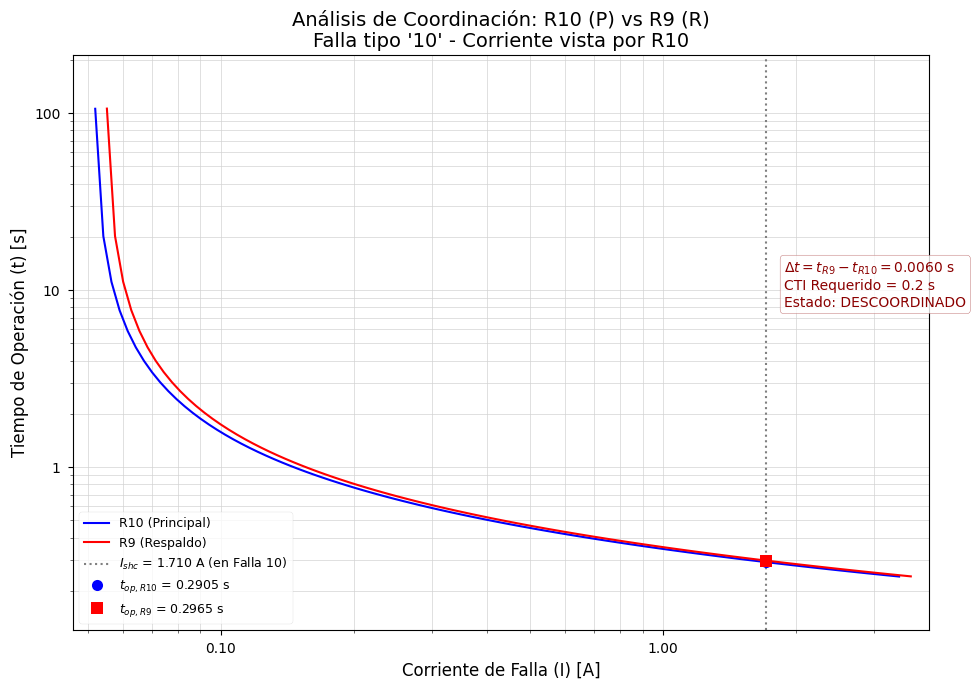


--- Generando Gráfica Detallada para R38(P) / R39(R) (Falla: 90) ---
  Registro encontrado: Falla=90, Ishc(Main)=0.98, Tmj=0.1989, Tbj=0.3989


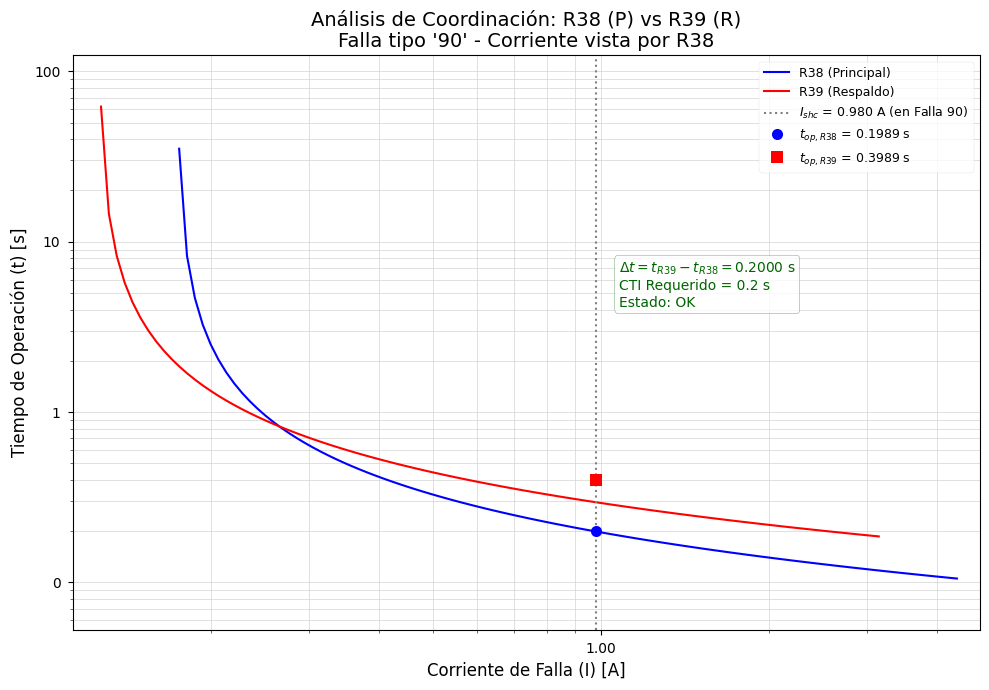


--- Fin del análisis detallado de pares seleccionados ---


In [16]:
# ... (Todo el código anterior incluyendo importaciones, funciones y carga/filtrado de datos) ...

# --- Función para Grafica Detallada de un Par (plot_detailed_pair_coordination) ---
# ... (La función es la misma que se definió en la respuesta anterior) ...
def plot_detailed_pair_coordination(main_relay_id, backup_relay_id, fault_context_id,
                                    scenario_data, relay_parameters_map, cti):
    # ... (Código interno de la función sin cambios) ...
    print(f"\n--- Generando Gráfica Detallada para {main_relay_id}(P) / {backup_relay_id}(R) (Falla: {fault_context_id}) ---")

    # 1. Encontrar el registro específico y extraer datos clave
    specific_record = None
    ishc_main_fault = None
    tmj_actual = None
    tbj_actual = None

    for record in scenario_data:
        main_relay_data = record.get('main_relay', {})
        backup_relay_data = record.get('backup_relay', {})
        record_fault = record.get('fault')

        if (main_relay_data.get('relay') == main_relay_id and
            backup_relay_data.get('relay') == backup_relay_id and
            str(record_fault) == str(fault_context_id)):
            ishc_main_fault = main_relay_data.get('Ishc')
            tmj_actual = main_relay_data.get('Time_out')
            tbj_actual = backup_relay_data.get('Time_out')
            specific_record = record
            print(f"  Registro encontrado: Falla={record_fault}, Ishc(Main)={ishc_main_fault}, Tmj={tmj_actual}, Tbj={tbj_actual}")
            break

    if ishc_main_fault is None or tmj_actual is None or tbj_actual is None:
        print(f"  ERROR: No se encontró registro/datos para {main_relay_id}/{backup_relay_id} Falla {fault_context_id}.")
        return
    if not isinstance(ishc_main_fault, (int, float)) or ishc_main_fault <= 0:
         print(f"  ERROR: Valor Ishc inválido ({ishc_main_fault}).")
         return
    if main_relay_id not in relay_parameters_map or backup_relay_id not in relay_parameters_map:
        print(f"  ERROR: Faltan parámetros Ipi/TDS para {main_relay_id} o {backup_relay_id}.")
        return

    main_params = relay_parameters_map[main_relay_id]
    backup_params = relay_parameters_map[backup_relay_id]

    # Calcular curvas
    min_M = 1.01
    # Calcular M basado en el Ipi de cada relé respectivo para el Ishc dado
    M_main_at_fault = ishc_main_fault / main_params['Ipi'] if main_params['Ipi'] > 0 else 1
    M_backup_at_fault = ishc_main_fault / backup_params['Ipi'] if backup_params['Ipi'] > 0 else 1 # Aproximación si Ishc(backup) no está disponible fácilmente
    max_M = max(25.0, M_main_at_fault * 2, M_backup_at_fault * 2)
    multiples_M = np.logspace(np.log10(min_M), np.log10(max_M), 100)

    main_currents, main_times = get_curve_points(main_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)
    backup_currents, backup_times = get_curve_points(backup_relay_id, relay_parameters_map, multiples_M, k_curve, n_curve)

    if main_currents is None or backup_currents is None:
        print(f"  ERROR: No se pudieron calcular puntos de curva.")
        return

    main_times_plus_cti = [t + cti for t in main_times]

    # Graficar con Matplotlib
    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.plot(main_currents, main_times, label=f"{main_relay_id} (Principal)", color='blue', linewidth=1.5)
    ax.plot(backup_currents, backup_times, label=f"{backup_relay_id} (Respaldo)", color='red', linewidth=1.5)
    # ax.plot(main_currents, main_times_plus_cti, label=f"{main_relay_id} + CTI ({cti}s)", color='blue', linestyle='--', linewidth=1)
    ax.axvline(x=ishc_main_fault, color='gray', linestyle=':', linewidth=1.5, label=f"$I_{{shc}}$ = {ishc_main_fault:.3f} A (en Falla {fault_context_id})")
    ax.plot(ishc_main_fault, tmj_actual, 'o', color='blue', markersize=8, label=f"$t_{{op, {main_relay_id}}}$ = {tmj_actual:.4f} s")
    ax.plot(ishc_main_fault, tbj_actual, 's', color='red', markersize=8, label=f"$t_{{op, {backup_relay_id}}}$ = {tbj_actual:.4f} s")

    ax.set_xscale('log')
    ax.set_yscale('log')
    min_curr_limit = min(main_params['Ipi'], backup_params['Ipi']) * 0.9
    max_curr_limit = max(max(main_currents), max(backup_currents)) * 1.1
    ax.set_xlim(left=min_curr_limit, right=max_curr_limit)
    min_time_limit = min(min(main_times), min(backup_times), tmj_actual, tbj_actual) * 0.5
    max_time_limit = max(max(main_times_plus_cti), max(backup_times), tmj_actual, tbj_actual) * 2.0
    try:
         # Asegurar que los límites sean válidos para la escala log
         effective_min_time = max(0.001, min_time_limit) # Establecer un mínimo absoluto pequeño
         effective_max_time = max(effective_min_time * 10, max_time_limit) # Asegurar que max > min
         ax.set_ylim(bottom=effective_min_time, top=effective_max_time)
    except ValueError as e:
         print(f"  - Advertencia: Problema ajustando límites del eje Y: {e}")


    delta_t_actual = tbj_actual - tmj_actual
    # Usar math.isclose para comparar flotantes con el CTI
    is_coordinated = math.isclose(delta_t_actual, cti, abs_tol=1e-4) or delta_t_actual > cti
    coord_status = "OK" if is_coordinated else "DESCOORDINADO"
    coord_text_color = "darkgreen" if is_coordinated else "darkred" # Verde más oscuro para OK

    text_x_pos = ishc_main_fault * 1.1 # Ajustar posición si es necesario
    # Calcular Y basado en los tiempos graficados para evitar superposición
    y_range = ax.get_ylim()
    text_y_pos = 10**(np.log10(y_range[0]) + 0.6 * (np.log10(y_range[1]) - np.log10(y_range[0]))) # Posición relativa en escala log

    ax.text(text_x_pos, text_y_pos,
            f"$\Delta t = t_{{{backup_relay_id}}} - t_{{{main_relay_id}}} = {delta_t_actual:.4f}$ s\n"
            f"CTI Requerido = {cti} s\n"
            f"Estado: {coord_status}",
            fontsize=10, verticalalignment='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8, ec=coord_text_color),
            color=coord_text_color)

    ax.set_xlabel("Corriente de Falla (I) [A]", fontsize=12)
    ax.set_ylabel("Tiempo de Operación (t) [s]", fontsize=12)
    ax.set_title(f"Análisis de Coordinación: {main_relay_id} (P) vs {backup_relay_id} (R)\nFalla tipo '{fault_context_id}' - Corriente vista por {main_relay_id}", fontsize=14)
    ax.legend(fontsize=9, loc='best') # Cambiado a 'best' para que Matplotlib elija
    ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=10)

    fig.tight_layout()
    plt.show()
    # fig.savefig(f"coordinacion_{main_relay_id}_{backup_relay_id}_falla_{fault_context_id}.png", dpi=300)

# --- Modificar Bloque Principal de Ejecución ---
if __name__ == "__main__":
    # ... (Código de carga de JSON, filtrado, extracción de parámetros - igual que antes) ...
    data = None
    scenario_data = None
    relay_parameters_map = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as f: data = json.load(f)
        print(f"Archivo JSON cargado: {file_path}")
    except Exception as e: print(f"Error cargando JSON: {e}"); exit()

    if isinstance(data, list): scenario_data = [item for item in data if item.get('scenario_id') == scenario_key_to_analyze]
    elif isinstance(data, dict): scenario_data = data.get(scenario_key_to_analyze, [])
    else: scenario_data = []
    if not isinstance(scenario_data, list): scenario_data = []
    if not scenario_data: print(f"No hay datos para {scenario_key_to_analyze}"); exit()

    relay_parameters_map = extract_relay_parameters(scenario_data)
    if not relay_parameters_map: print("No se extrajeron parámetros."); exit()

    # --- LLAMADAS A LA FUNCIÓN DE GRÁFICA DETALLADA ---

    # 1. Gráfica para R10 / R9 (Descoordinado)
    plot_detailed_pair_coordination(main_relay_id='R10',
                                    backup_relay_id='R9',
                                    fault_context_id='10', # Asegúrate que coincida con tu JSON
                                    scenario_data=scenario_data,
                                    relay_parameters_map=relay_parameters_map,
                                    cti=cti)

    # 2. Gráfica para R38 / R39 (Coordinado)
    plot_detailed_pair_coordination(main_relay_id='R38',
                                    backup_relay_id='R39',
                                    fault_context_id='90', # Asegúrate que coincida con tu JSON
                                    scenario_data=scenario_data,
                                    relay_parameters_map=relay_parameters_map,
                                    cti=cti)

    # --- Fin del Script ---
    print("\n--- Fin del análisis detallado de pares seleccionados ---")